# IMPORTS

In [1]:
import tensorflow as tf
print("Tensorflow version : %s" % tf.__version__)

import csv
import time
import random
import glob
import os
import numpy as np
from math import ceil
import warnings

from deeplearning_tools.loss_functions import Multiclass_DSC_Loss
from deeplearning_tools.loss_functions import Tumoral_DSC
from global_tools.tools import display_learning_curves
from class_modalities.modality_PETCT import Modality_TRAINING_PET_CT

Tensorflow version : 2.0.0


##### HOW TO WRITE FILENAMES IN A CSV FILE

# RULES

In [2]:
# REQUIRED : .csv file containing all images filenames per patient
#           example : patient n°1 | PET | CT | MASK |
#                     patient n°2 | PET | CT | MASK |
#                     etc

csv_filenames = "/media/storage/projet_LYSA_TEP_3.5/TEP_CT_training_filenames.csv"

# definition of modality
MODALITY = Modality_TRAINING_PET_CT()

# path folders
path_preprocessed = '/media/storage/projet_LYSA_TEP_3.5/PREPROCESS_PETCT_4'
path_results = '/media/storage/projet_LYSA_TEP_3.5/RESULTS_PETCT_4'

# generates folders
if not os.path.exists(path_preprocessed):
    os.makedirs(path_preprocessed)
if not os.path.exists(path_results):
    os.makedirs(path_results)
    
# preprocess parameters
PREPROCESS_DATA = False
visualisation_preprocessed_files = True
IMAGE_SHAPE  = [368,128,128]
PIXEL_SIZE   = [4.8,4.8,4.8]
DATA_AUGMENT = True
RESIZE       = True
NORMALIZE    = True 

# training parameters
trained_model_path = '/media/storage/projet_LYSA_TEP_3.5/RESULTS_PETCT_4/model_09250922.h5' # or None
if trained_model_path is None:
    # CNN that will be generated and trained
    from deeplearning_models.Unet import custom_Unet3D as CNN
    
SHUFFLE = True
labels_names   = MODALITY.labels_names   # example for TEP :['Background','Lymphoma',]
labels_numbers = MODALITY.labels_numbers #                 :[0,1]
ITERATIONS = 50000
BATCH_SIZE = 2
GPU_NB=2

# visualisation parameters
PREDICTION_TRAINING_SET   = False #(for development or verification purpose)
PREDICTION_VALIDATION_SET = True
PREDICTION_TEST_SET       = False #(final trained model only)
saving_directives = {
    'Save history'      : True,
    'Save model'        : True
}

# PREPROCESSING

In [3]:
if PREPROCESS_DATA:

    # read filenames from csv file
    all_patients_filenames = []
    with open(csv_filenames,"r") as file:
        filereader = csv.reader(file)
        for row in filereader:
            all_patients_filenames.append(row)

    # define training / validation / tests sets : 80% / 10% / 10%
    BUFFER_SIZE = len(all_patients_filenames)
    random.shuffle(all_patients_filenames)
    valid_set = all_patients_filenames[slice(0,ceil(0.1*BUFFER_SIZE))]
    test_set  = all_patients_filenames[slice(ceil(0.1*BUFFER_SIZE),ceil(0.2*BUFFER_SIZE))]
    train_set = all_patients_filenames[slice(ceil(0.2*BUFFER_SIZE),BUFFER_SIZE)]

    preprocessed_sets = {'TRAIN_SET':None,'VALID_SET':None,'TEST_SET':None}
    
    # loop overs sets
    for folder,data_set_ids in zip(['TRAIN_SET','VALID_SET','TEST_SET'],[train_set,valid_set,test_set]):

        print("Preprocessing : %s" % folder)
        
        # generates folder
        directory = path_preprocessed+'/'+folder
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        # preprocess files
        preprocessed_sets[folder] = MODALITY.PREPROCESS(data_set_ids,
                                                        path_output=directory,
                                                        output_shape=IMAGE_SHAPE,
                                                        pixel_size=PIXEL_SIZE,
                                                        resample=RESIZE,
                                                        normalize=NORMALIZE)     
        print('')

    if DATA_AUGMENT: # perform only on train set
        print("Data augmentation :")

        preprocessed_sets['TRAIN_SET'] += MODALITY.DATA_AUGMENTATION(preprocessed_sets['TRAIN_SET'],
                                                                     augmentation_factor=3)
        print('')

    if visualisation_preprocessed_files:
        print("Generation MIP .pdf :")
        MODALITY.VISUALISATION_MIP_PREPROCESS(path_preprocessed,
                                              preprocessed_sets['TRAIN_SET'],
                                              filename="MIP_preprocessed_training_data.pdf")
        print('') 
        MODALITY.VISUALISATION_MIP_PREPROCESS(path_preprocessed,
                                              preprocessed_sets['VALID_SET'],
                                              filename="MIP_preprocessed_validation_data.pdf")
        print('') 
        MODALITY.VISUALISATION_MIP_PREPROCESS(path_preprocessed,
                                              preprocessed_sets['TEST_SET'],
                                              filename="MIP_preprocessed_test_data.pdf")
        print('') 

else:
    # load previously generated files
    warnings.warn("Not preprocessing datas, be sure to know what you're doing")
    
    preprocessed_sets = {'TRAIN_SET':None,'VALID_SET':None,'TEST_SET':None}
    
    for folder in ['TRAIN_SET','VALID_SET','TEST_SET']:
        
        directory = path_preprocessed+'/'+folder
        
        PET_ids = np.sort(glob.glob(directory+'/*float*.nii'))
        CT_ids = np.sort(glob.glob(directory+'/*ctUh*.nii'))
        MASK_ids = np.sort(glob.glob(directory+'/*pmask*.nii'))
        
        preprocessed_sets[folder] = list(zip(PET_ids,CT_ids,MASK_ids))
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Not preprocessing datas, be sure to know what you're doing


# TRAINING

In [4]:
# shuffle training data
if SHUFFLE:
    random.shuffle(preprocessed_sets['TRAIN_SET'])
    
# preparation of tensorflow DATASETS
train_generator = MODALITY.get_GENERATOR(preprocessed_sets['TRAIN_SET'])
train_dataset = tf.data.Dataset.from_generator(train_generator.call,train_generator.types,train_generator.shapes).batch(BATCH_SIZE).repeat()

valid_generator = MODALITY.get_GENERATOR(preprocessed_sets['VALID_SET'])
valid_dataset = tf.data.Dataset.from_generator(valid_generator.call,valid_generator.types,valid_generator.shapes).batch(BATCH_SIZE).repeat()

# MODEL PREPARATION
epochs = int(ITERATIONS/len(preprocessed_sets['TRAIN_SET']))

strategy = tf.distribute.MirroredStrategy()

if trained_model_path is None:
    # GENERATE NEW MODEL
    number_channels = MODALITY.number_channels
    cnn_img_shape = tuple(IMAGE_SHAPE.copy()+[number_channels])
    with strategy.scope():
        model = CNN(cnn_img_shape,len(labels_names)).get_model()

else:
    # LOAD MODEL FROM .h5 FILE
    with strategy.scope():
        model = tf.keras.models.load_model(trained_model_path,compile=False)


# definition of loss, optimizer and metrics
loss_object = Multiclass_DSC_Loss()
metrics = [Tumoral_DSC(),tf.keras.metrics.SparseCategoricalCrossentropy(name='SCCE'),]
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.1)

# TODO : generate a learning rate scheduler
with strategy.scope():
    model.compile(loss=loss_object,optimizer=optimizer,metrics=metrics)

In [5]:
# LEARNING PROCEDURE

start_tt = time.time()

history = model.fit(
    x=train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=int(len(preprocessed_sets['TRAIN_SET'])/BATCH_SIZE),
    validation_steps=int(len(preprocessed_sets['VALID_SET'])/BATCH_SIZE),
    epochs=epochs)

# TIMER
total_tt = time.time() - start_tt
hours = int(total_tt//3600)
mins = int((total_tt-hours*3600)//60)
sec = int((total_tt-hours*3600-mins*60))
print("\n\nRun time = "+str(hours)+':'+str(mins)+':'+str(sec)+' (H:M:S)')

Train for 175 steps, validate for 7 steps
Epoch 1/142
175/175 [==============================] - 372s 2s/step - loss: 0.1638 - tumoral_dsc_metric: 0.6782 - SCCE: 0.0054 - val_loss: 0.1255 - val_tumoral_dsc_metric: 0.7533 - val_SCCE: 0.0050
Epoch 2/142
175/175 [==============================] - 339s 2s/step - loss: 0.1622 - tumoral_dsc_metric: 0.6816 - SCCE: 0.0054 - val_loss: 0.1227 - val_tumoral_dsc_metric: 0.7593 - val_SCCE: 0.0050
Epoch 3/142
175/175 [==============================] - 333s 2s/step - loss: 0.1616 - tumoral_dsc_metric: 0.6827 - SCCE: 0.0052 - val_loss: 0.1226 - val_tumoral_dsc_metric: 0.7587 - val_SCCE: 0.0049
Epoch 4/142
175/175 [==============================] - 332s 2s/step - loss: 0.1629 - tumoral_dsc_metric: 0.6796 - SCCE: 0.0056 - val_loss: 0.1257 - val_tumoral_dsc_metric: 0.7521 - val_SCCE: 0.0050
Epoch 5/142
175/175 [==============================] - 338s 2s/step - loss: 0.1614 - tumoral_dsc_metric: 0.6826 - SCCE: 0.0053 - val_loss: 0.1264 - val_tumoral_dsc_me

175/175 [==============================] - 338s 2s/step - loss: 0.1614 - tumoral_dsc_metric: 0.6827 - SCCE: 0.0054 - val_loss: 0.1252 - val_tumoral_dsc_metric: 0.7533 - val_SCCE: 0.0051
Epoch 43/142
175/175 [==============================] - 338s 2s/step - loss: 0.1594 - tumoral_dsc_metric: 0.6867 - SCCE: 0.0053 - val_loss: 0.1265 - val_tumoral_dsc_metric: 0.7511 - val_SCCE: 0.0052
Epoch 44/142
175/175 [==============================] - 339s 2s/step - loss: 0.1623 - tumoral_dsc_metric: 0.6809 - SCCE: 0.0053 - val_loss: 0.1270 - val_tumoral_dsc_metric: 0.7499 - val_SCCE: 0.0052
Epoch 45/142
175/175 [==============================] - 334s 2s/step - loss: 0.1609 - tumoral_dsc_metric: 0.6837 - SCCE: 0.0055 - val_loss: 0.1266 - val_tumoral_dsc_metric: 0.7508 - val_SCCE: 0.0049
Epoch 46/142
175/175 [==============================] - 336s 2s/step - loss: 0.1627 - tumoral_dsc_metric: 0.6806 - SCCE: 0.0053 - val_loss: 0.1247 - val_tumoral_dsc_metric: 0.7546 - val_SCCE: 0.0048
Epoch 47/142
175/1

175/175 [==============================] - 339s 2s/step - loss: 0.1628 - tumoral_dsc_metric: 0.6799 - SCCE: 0.0054 - val_loss: 0.1259 - val_tumoral_dsc_metric: 0.7519 - val_SCCE: 0.0053
Epoch 84/142
175/175 [==============================] - 340s 2s/step - loss: 0.1601 - tumoral_dsc_metric: 0.6846 - SCCE: 0.0053 - val_loss: 0.1262 - val_tumoral_dsc_metric: 0.7509 - val_SCCE: 0.0050
Epoch 85/142
175/175 [==============================] - 340s 2s/step - loss: 0.1610 - tumoral_dsc_metric: 0.6835 - SCCE: 0.0054 - val_loss: 0.1239 - val_tumoral_dsc_metric: 0.7562 - val_SCCE: 0.0050
Epoch 86/142
175/175 [==============================] - 338s 2s/step - loss: 0.1602 - tumoral_dsc_metric: 0.6853 - SCCE: 0.0054 - val_loss: 0.1241 - val_tumoral_dsc_metric: 0.7557 - val_SCCE: 0.0050
Epoch 87/142
175/175 [==============================] - 344s 2s/step - loss: 0.1636 - tumoral_dsc_metric: 0.6787 - SCCE: 0.0054 - val_loss: 0.1232 - val_tumoral_dsc_metric: 0.7575 - val_SCCE: 0.0051
Epoch 88/142
175/1

175/175 [==============================] - 344s 2s/step - loss: 0.1610 - tumoral_dsc_metric: 0.6837 - SCCE: 0.0053 - val_loss: 0.1228 - val_tumoral_dsc_metric: 0.7584 - val_SCCE: 0.0048
Epoch 125/142
175/175 [==============================] - 344s 2s/step - loss: 0.1630 - tumoral_dsc_metric: 0.6794 - SCCE: 0.0053 - val_loss: 0.1238 - val_tumoral_dsc_metric: 0.7562 - val_SCCE: 0.0049
Epoch 126/142
175/175 [==============================] - 345s 2s/step - loss: 0.1614 - tumoral_dsc_metric: 0.6827 - SCCE: 0.0052 - val_loss: 0.1262 - val_tumoral_dsc_metric: 0.7513 - val_SCCE: 0.0049
Epoch 127/142
175/175 [==============================] - 342s 2s/step - loss: 0.1599 - tumoral_dsc_metric: 0.6861 - SCCE: 0.0054 - val_loss: 0.1264 - val_tumoral_dsc_metric: 0.7509 - val_SCCE: 0.0049
Epoch 128/142
175/175 [==============================] - 346s 2s/step - loss: 0.1625 - tumoral_dsc_metric: 0.6807 - SCCE: 0.0055 - val_loss: 0.1240 - val_tumoral_dsc_metric: 0.7558 - val_SCCE: 0.0048
Epoch 129/142


# VISUALISATION

Learning curves :


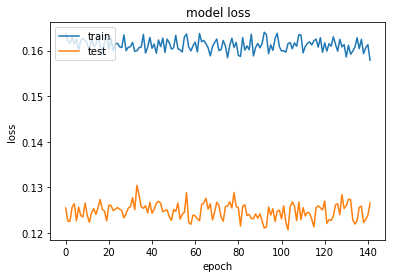

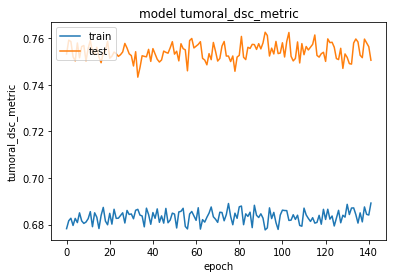

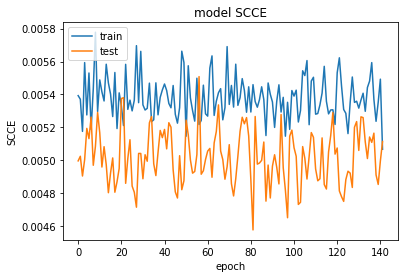

Saving history: /media/storage/projet_LYSA_TEP_3.5/RESULTS_PETCT_4/history_10020819.dat


In [6]:
# plot learning curves and save history
if history:
    
    print("Learning curves :")
    display_learning_curves(history)

    if saving_directives['Save history']:
        filename = path_results+"/history_"+time.strftime("%m%d%H%M")+".dat"
        print("Saving history: %s" % filename)
        with open(filename,'w') as file:
            file.write(str(history.history))

In [1]:
# save only weights model as .h5 file
if saving_directives['Save model']:
    filename = path_results+"/weights_"+time.strftime("%m%d%H%M")+".h5"
    print("Saving model : %s" % filename)
    model.save_weights(filename)

NameError: name 'saving_directives' is not defined

In [ ]:
# save whole model as .h5 file
if saving_directives['Save model']:
    filename = path_results+"/model_"+time.strftime("%m%d%H%M")+".h5"
    print("Saving model : %s" % filename)
    model.save(filename)

In [ ]:
if PREDICTION_TRAINING_SET:
    print("Prediction on training set : /!\ use only for development or verification purpose")
   
    n_sample = min(20,len(preprocessed_sets['TRAIN_SET'])) #number of training imgs visualised
    random.shuffle(preprocessed_sets['TRAIN_SET'])
    
    filename = "/RESULTS_train_set_"+time.strftime("%m%d%H%M%S")+".pdf"
    
    print("Generating predictions :")
    train_prediction_ids = MODALITY.PREDICT_MASK(data_set_ids=preprocessed_sets['TRAIN_SET'][:n_sample],
                                                 path_predictions=path_results+'/train_predictions',
                                                 model=model)
    
    print("\nDisplaying stats and MIP : %s" % filename)
    MODALITY.VISUALISATION_MIP_PREDICTION(path_results,
                                          data_set_ids=preprocessed_sets['TRAIN_SET'][:n_sample],
                                          pred_ids=train_prediction_ids,
                                          filename=filename)

In [ ]:
if PREDICTION_VALIDATION_SET:
    print("Prediction on validation set :")
    # use to fine tune and evaluate model performances
    
    filename = "/RESULTS_valid_set_"+time.strftime("%m%d%H%M%S")+".pdf"
    
    print("Generating predictions :")
    valid_prediction_ids = MODALITY.PREDICT_MASK(data_set_ids=preprocessed_sets['VALID_SET'],
                                                 path_predictions=path_results+'/valid_predictions',
                                                 model=model)
    
    print("\nDisplaying stats and MIP : %s" % filename)
    MODALITY.VISUALISATION_MIP_PREDICTION(path_results,
                                          data_set_ids=preprocessed_sets['VALID_SET'],
                                          pred_ids=valid_prediction_ids,
                                          filename=filename)


Prediction on validation set :
Generating predictions :
1/15 [==>----------------------------] : src_all_se_mar_28_2013_float.nii    

In [ ]:
if PREDICTION_TEST_SET:
    print("Prediction on test set : /!\ use only on fully trained model")

    filename = "/RESULTS_test_set_"+time.strftime("%m%d%H%M%S")+".pdf"
    
    print("Generating predictions :")
    test_prediction_ids = MODALITY.PREDICT_MASK(data_set_ids=preprocessed_sets['TEST_SET'],
                                                 path_predictions=path_results+'/test_predictions',
                                                 model=model)
    
    print("\nDisplaying stats and MIP : %s" % filename)
    MODALITY.VISUALISATION_MIP_PREDICTION(path_results,
                                          data_set_ids=preprocessed_sets['TEST_SET'],
                                          pred_ids=test_prediction_ids,
                                          filename=filename)